In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
import os
import glob
import pdb
import warnings
from utils import *
from pnc_parser import sync_pnc_data
warnings.filterwarnings('ignore')

TODO: Write a script to combine new finance data with old data

In [148]:
INPUT_DATA_DIR = 'data'
OUTPUT_DATA_DIR = 'output'

## TODO: Do -ve +ve transactions in PNC ✅

## TODO: Add emoji after each enum text to visually identify fast
## TODO: Parse PNC from pdfs (monthly statement) and combine ✅
## TODO: Script to download statements
## TODO: Make a barchart showing start-end date of each account

# * Don't have _notes.csv. Instead keep only one copy.
# * Keep original name of files with account number mentioned
# * For each csv, write summary of earliest & last date so as to ensure if all data loaded

class AccHolder(Enum):
    SACHIN = 'sachin'
    NOWRIN = 'nowrin'
    JOINT = 'joint'

class BankName(Enum):
    PNC = 'pnc'
    DISCOVER = 'discover'
    CHASE = 'chase'
    
class AccType(Enum):
    CHECKING = 'checking'
    CREDIT = 'credit'
    SAVINGS = 'savings'

In [149]:
CHASE_ACC_MAP = {
    AccHolder.SACHIN: {
        AccType.CHECKING: "5231",
        AccType.SAVINGS: "1756"
    },
    AccHolder.NOWRIN: {
        AccType.CHECKING: "7138",
        AccType.SAVINGS: "2267",
        AccType.CREDIT: ["6562", "7345"]
    },
    AccHolder.JOINT: {
        AccType.CHECKING: "7386",
        AccType.CREDIT: "6611"
    }
}   # 8 accounts

In [165]:
class Bank:
    def __init__(self, owner, acc_type, bank_name):
        self.owner = owner
        self.acc_type = acc_type
        self.bank_name = bank_name
        self.data = None

    def is_data_loaded(self):
        return not self.data is None

    def get_data(self):
        return self.data

    def load_data(self):
        pass

    def clean_data(self):
        data = self.data
        data['Date'] = pd.to_datetime(data['Date'])
        data.rename(columns={"Category": "AutoCategory"}, inplace=True)
        data['AccHolder'] = self.owner.value
        data['BankName'] = self.bank_name.value
        data['AccType'] = self.acc_type.value

        interested_columns = ['Date', 'Description', 'Amount', 'AutoCategory', 'AccHolder',
                            'BankName', 'AccType']
        data = data[interested_columns]
        self.data = data

class Chase(Bank):
    def __init__(self, owner, acc_type):
        super().__init__(owner, acc_type, BankName.CHASE)

    def load_data(self):
        code = None
        if self.acc_type in CHASE_ACC_MAP[self.owner]:
            code = CHASE_ACC_MAP[self.owner][self.acc_type]
        if not code: return None
        if isinstance(code, str):
            code = [code]

        dataframes = []
        for cd in code:
            filename = f'Chase{cd}_Activity*.CSV'
            matched_files = glob.glob(f'{INPUT_DATA_DIR}/chase/{filename}')
            if len(matched_files) == 0:
                print(f"Error: File missing for code: {cd}")
            elif len(matched_files) > 1:
                print(f"Error: Multiple files for code: {cd}")
            df = pd.read_csv(matched_files[0], index_col=False)
            dataframes.append(df)

        self.data = pd.concat(dataframes, ignore_index=True)

    def clean_data(self):
        data = self.data
        if data is None: return
        if self.acc_type == AccType.CREDIT:
            data['Date'] = data['Transaction Date']
        else:
            data['Date'] = data['Posting Date']
            data['Category'] = ''

        super().clean_data()

class PNC(Bank):
    def __init__(self, owner, acc_type):
        super().__init__(owner, acc_type, BankName.PNC)

    def load_data(self):
        if self.owner == AccHolder.JOINT:
            return
        if not self.acc_type == AccType.CHECKING:
            return       
        self.data = pd.read_csv(f'{INPUT_DATA_DIR}/pnc/{self.owner.value}.csv', index_col=False)

    def clean_data(self):
        data = self.data
        if data is None: return
        data['Category'] = ''
        # data['Amount'] = 0.0
        # data['Amount'] -= convert_currency_to_num(data['Withdrawals'])
        # data['Amount'] += convert_currency_to_num(data['Deposits'])

        super().clean_data()

class Discover(Bank):
    def __init__(self, owner, acc_type):
        super().__init__(owner, acc_type, BankName.DISCOVER)

    def load_data(self):
        if not self.owner == AccHolder.SACHIN:
            return
        if not self.acc_type == AccType.CREDIT:
            return
        dataframes = []
        filename = f'Discover-Last12Months-*.csv'
        matched_files = glob.glob(f'{INPUT_DATA_DIR}/discover/{filename}')
        if len(matched_files) == 0:
            print(f"Error: File missing")
        elif len(matched_files) > 1:
            print(f"Error: Multiple files")
        df = pd.read_csv(matched_files[0], index_col=False)
        dataframes.append(df)

        self.data = pd.concat(dataframes, ignore_index=True)
        
    def clean_data(self):
        data = self.data
        if data is None: return
        data['Amount'] *= -1
        data['Date'] = data['Trans. Date']

        super().clean_data()

In [151]:
# def preprocess_data(filename):
#     account_holder, bank_name, account_type, *_ = filename.split('_')
#     try:
#         account_holder, bank_name, account_type = AccHolder(account_holder), BankName(bank_name), AccType(account_type)
#     except(ValueError):
#         print("Invalid filename:", filename)

#     data = pd.read_csv(f'{INPUT_DATA_DIR}/{filename}', index_col=False)

#     if bank_name == BankName.PNC:
#         data['Amount'] = 0.0
#         data['Amount'] -= convert_currency_to_num(data['Withdrawals'])
#         data['Amount'] += convert_currency_to_num(data['Deposits'])
#     if bank_name == BankName.CHASE and account_type == AccType.CHECKING:
#         data['Date'] = data['Posting Date']
#         data['Category'] = ''
#     if bank_name == BankName.CHASE:
#         if account_type == AccType.CREDIT:
#             data['Date'] = data['Transaction Date']
#         else:
#             data['Date'] = data['Posting Date']
#             data['Category'] = ''
#     if bank_name == BankName.DISCOVER:
#         data['Amount'] *= -1
#         data['Date'] = data['Trans. Date']

#     data['Date'] = pd.to_datetime(data['Date'])
#     data.rename(columns={"Category": "AutoCategory"}, inplace=True)
#     data['AccHolder'] = account_holder.value
#     data['BankName'] = bank_name.value
#     data['AccType'] = account_type.value

#     interested_columns = ['Date', 'Description', 'Amount', 'AutoCategory', 'AccHolder',
#                           'BankName', 'AccType']
#     data = data[interested_columns]
#     return data


In [166]:
def get_obj(owner, bank, acc_type):
    if bank == BankName.CHASE:
        return Chase(owner=owner, acc_type=acc_type)
    elif bank == BankName.PNC:
        return PNC(owner=owner, acc_type=acc_type)
    elif bank == BankName.DISCOVER:
        return Discover(owner=owner, acc_type=acc_type)

def merge_all_data():
    data_list = []
    for owner in AccHolder:
        for bank in BankName:
            for acc_type in AccType:
                obj = get_obj(owner, bank, acc_type)
                if not obj: continue
                obj.load_data()
                if not obj.is_data_loaded(): continue
                obj.clean_data()
                data_list.append(obj.get_data())

    full_data = pd.concat(data_list)
    full_data = full_data.sort_values(by=['Date', 'Amount'])
    full_data['AutoCategory'].fillna('', inplace=True)
    return full_data

# sync_pnc_data(INPUT_DATA_DIR)
data = merge_all_data()
data.head()
data.to_csv(f'{OUTPUT_DATA_DIR}/full_data.csv', index=False)

In [167]:
data = pd.read_csv(f'{OUTPUT_DATA_DIR}/full_data.csv', index_col=False)
data['Date'] = pd.to_datetime(data['Date'])

In [168]:
def summary_statistics(df_full):
    def summary(df):
        no_of_entries = len(df)
        oldest_date = df['Date'].dt.date.min()
        newest_date = df['Date'].dt.date.max()
        summary_data['AccHolder'].append(bank.value)
        summary_data['BankName'].append(owner.value)
        summary_data['AccType'].append(acc_type.value)
        summary_data['Start_Date'].append(oldest_date)
        summary_data['End_Date'].append(newest_date)
        summary_data['Entries'].append(no_of_entries)

    summary_data = {
        'BankName': [],
        'AccHolder': [],
        'AccType': [],
        'Start_Date': [],
        'End_Date': [],
        'Entries': []
    }
    for owner in AccHolder:
        for bank in BankName:
            for acc_type in AccType:
                df = df_full.query('AccHolder == @owner.value and BankName == @bank.value and AccType == @acc_type.value')
                if len(df):
                    summary(df)

    summary_df = pd.DataFrame(summary_data)
    summary_df['Start_Date'] = pd.to_datetime(summary_df['Start_Date'])
    summary_df['End_Date'] = pd.to_datetime(summary_df['End_Date'])
    return summary_df

summary_df = summary_statistics(data)

In [169]:
summary_df

,BankName,AccHolder,AccType,Start_Date,End_Date,Entries
0,sachin,pnc,checking,2022-08-31,2023-04-13,220
1,sachin,discover,credit,2023-02-05,2023-08-05,142
2,sachin,chase,checking,2022-08-23,2023-08-15,107
3,sachin,chase,savings,2022-08-23,2023-08-01,11
4,nowrin,pnc,checking,2022-08-31,2023-06-21,259
5,nowrin,chase,checking,2022-08-23,2023-08-22,130
6,nowrin,chase,credit,2023-01-06,2023-08-17,94
7,nowrin,chase,savings,2022-08-23,2023-08-15,27
8,joint,chase,checking,2023-03-20,2023-08-22,104
9,joint,chase,credit,2023-03-25,2023-08-20,269


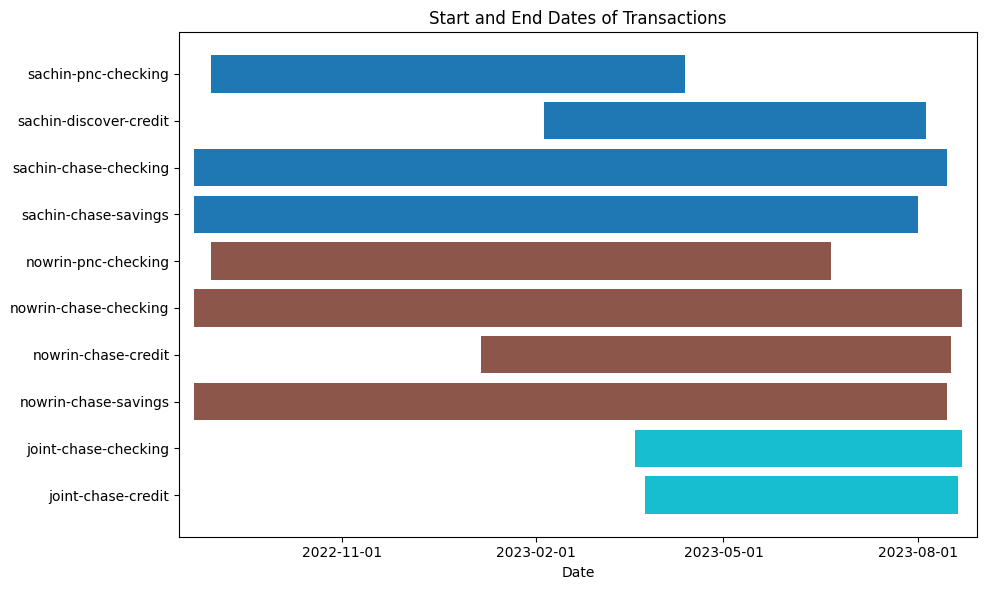

In [170]:
from datetime import datetime, timedelta

def visualize_summary(df):
    # Get unique values in column X and create a colormap
    unique_x_values = df['BankName'].unique()
    num_unique_values = len(unique_x_values)
    color_map = plt.get_cmap('tab10', num_unique_values)
    x_to_color = {x_value: color_map(i) for i, x_value in enumerate(unique_x_values)}
    df['Color'] = df['BankName'].map(x_to_color)

    # Plotting the horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(df['BankName']+'-'+df['AccHolder']+'-'+df['AccType'], df['End_Date'] - df['Start_Date'],
    left=df['Start_Date'], color=df['Color'])
    plt.xlabel('Date')
    # plt.ylabel('Item')
    plt.title('Start and End Dates of Transactions')
    plt.tight_layout()

    # Formatting date on x-axis
    date_format = '%Y-%m-%d'
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(date_format))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=3))

    # Adding margin to the left of the x-axis
    margin = timedelta(days=7)  # Adjust the number of days for the desired margin
    x_min = df['Start_Date'].min() - margin
    x_max = df['End_Date'].max() + margin
    plt.gca().set_xlim(x_min, x_max)

    # Inverting y-axis
    plt.gca().invert_yaxis()

    plt.show()

visualize_summary(summary_df)

In [23]:
def _merge_all_data():
    data_list = []
    file_list = os.listdir(INPUT_DATA_DIR)
    file_list = [file for file in file_list if file.endswith('.csv')]
    for filename in file_list:
        data = preprocess_data(filename)
        data_list.append(data)
    full_data = pd.concat(data_list)
    full_data = full_data.sort_values(by=['Date', 'Amount'])
    full_data['AutoCategory'].fillna('', inplace=True)
    return full_data

In [68]:
data = merge_all_data()

Name: SACHIN
Value: sachin
Name: SACHIN
Value: sachin
Name: SACHIN
Value: sachin
Name: SACHIN
Value: sachin
Name: SACHIN
Value: sachin
Name: SACHIN
Value: sachin
Name: SACHIN
Value: sachin
Name: SACHIN
Value: sachin
Name: SACHIN
Value: sachin
Name: NOWRIN
Value: nowrin
Name: NOWRIN
Value: nowrin
Name: NOWRIN
Value: nowrin
Name: NOWRIN
Value: nowrin
Name: NOWRIN
Value: nowrin
Name: NOWRIN
Value: nowrin
Name: NOWRIN
Value: nowrin
Name: NOWRIN
Value: nowrin
Name: NOWRIN
Value: nowrin
Name: JOINT
Value: joint
Name: JOINT
Value: joint
Name: JOINT
Value: joint
Name: JOINT
Value: joint
Name: JOINT
Value: joint
Name: JOINT
Value: joint
Name: JOINT
Value: joint
Name: JOINT
Value: joint
Name: JOINT
Value: joint


In [25]:
YEAR = 2023
MONTH = 6
data = filter_data_by_date(data, YEAR, MONTH)
data.to_csv(f'{OUTPUT_DATA_DIR}/{YEAR}_{MONTH}.csv', index=False)

In [26]:
data.head(20)

,Date,Description,Amount,AutoCategory,AccHolder,BankName,AccType
55,2023-06-01,KROGER 605,-23.80,Groceries,joint,chase,credit
53,2023-06-01,DD DOORDASH MARCOSPIZ,-15.90,Food & Drink,joint,chase,credit
46,2023-06-01,TST* Jojos Shake Bar - D,-15.88,Food & Drink,joint,chase,credit
49,2023-06-01,PATEL BROTHERS OF ANN ARB,-12.25,Groceries,joint,chase,credit
56,2023-06-01,KROGER 605,-4.69,Groceries,joint,chase,credit
57,2023-06-01,TST* PICASSO NCRC,-2.99,Food & Drink,joint,chase,credit
51,2023-06-01,MARKET@WORK 2067379149,-2.29,Food & Drink,joint,chase,credit
26,2023-06-02,Zelle payment to Smit Kothari 17521925843,-606.72,,joint,chase,checking
27,2023-06-02,Online Transfer to CHK ...5231 transaction#: 1...,-50.00,,joint,chase,checking
54,2023-06-02,DOORDASH DASHPASS,-4.99,Food & Drink,joint,chase,credit
